In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
# Loading in CIFAR dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./', train=False, download=True, transform=transform)

In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [4]:
class mnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,5*5*16)
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = mnistCNN()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
model.to(device)

mnistCNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
total_params = 0
for p in model.parameters():
    total_params += p.numel()
    print(p.numel())
print('Total parameters:',total_params)

54
6
864
16
48000
120
10080
84
840
10
Total parameters: 60074


In [8]:
import time

In [9]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    print(f'================================================== Epoch {i} ==================================')
    trn_corr = 0
    tst_corr = 0
    
    # Train batch
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train,y_train = X_train.to(device), y_train.to(device)
        b+=1
        
        # Applying model and finding the loss
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Grabbing number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Printing results every 1000 batches of each epoch
        if b%1000 == 0:
            print(f'Batch {b} out of 5000: \t Loss: {loss} \t Accuracy: {round(trn_corr.item()*100/(10*b),2)}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Test batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test,y_test = X_test.to(device),y_test.to(device)

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    print('\n')
        
print(f'Time: {round(time.time() - start_time,2)} seconds')          

================================================== Epoch 0 ==================================
Batch 1000 out of 5000: 	 Loss: 1.0435616970062256 	 Accuracy: 85.93%
Batch 2000 out of 5000: 	 Loss: 0.2407795637845993 	 Accuracy: 90.69%
Batch 3000 out of 5000: 	 Loss: 0.013379109092056751 	 Accuracy: 92.52%
Batch 4000 out of 5000: 	 Loss: 0.015344488434493542 	 Accuracy: 93.62%
Batch 5000 out of 5000: 	 Loss: 0.006657543126493692 	 Accuracy: 94.38%
Batch 6000 out of 5000: 	 Loss: 0.15658287703990936 	 Accuracy: 94.87%


================================================== Epoch 1 ==================================
Batch 1000 out of 5000: 	 Loss: 0.026912514120340347 	 Accuracy: 98.21%
Batch 2000 out of 5000: 	 Loss: 0.0003723484114743769 	 Accuracy: 98.15%
Batch 3000 out of 5000: 	 Loss: 0.002896849764510989 	 Accuracy: 98.19%
Batch 4000 out of 5000: 	 Loss: 0.037114467471838 	 Accuracy: 98.22%
Batch 5000 out of 5000: 	 Loss: 0.009718534536659718 	 Accuracy: 98.2%
Batch 6000 out of 5000: 	 

In [20]:
train_acc = [t/600 for t in train_correct]
test_acc = [t/100 for t in test_correct]

In [21]:
train_acc

[tensor(94.8717),
 tensor(98.1700),
 tensor(98.6233),
 tensor(98.8967),
 tensor(99.0517)]

In [22]:
test_acc

[tensor(97.4400),
 tensor(98.3300),
 tensor(98.3600),
 tensor(98.7500),
 tensor(98.5500)]

In [23]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu()
for i in range(len(test_acc)):
    test_acc[i] = test_acc[i].cpu()

In [24]:
for i in range(len(train_correct)):
    train_correct[i] = train_correct[i].cpu()
for i in range(len(test_correct)):
    test_correct[i] = test_correct[i].cpu()

In [25]:
for i in range(len(train_losses)):
    train_losses[i] = train_losses[i].detach().cpu()
for i in range(len(test_losses)):
    test_losses[i] = test_losses[i].detach().cpu()

In [26]:
print('=================================== Train and Test metrics:Loss and accuracy =======================')
for i in range(epochs):
    print(f'Epoch {i}: Train Loss:{round(train_losses[i].item(),2)} Train Accuracy: {round(train_acc[i].item(),2)} % \tTest Loss: {round(test_losses[i].item(),2)} Test Accuracy: {round(test_acc[i].item(),2)} % ')

=================================== Train and Test metrics:Loss and accuracy =======================
Epoch 0: Train Loss:0.16 Train Accuracy: 94.87 % 	Test Loss: 0.0 Test Accuracy: 97.44 % 
Epoch 1: Train Loss:0.0 Train Accuracy: 98.17 % 	Test Loss: 0.0 Test Accuracy: 98.33 % 
Epoch 2: Train Loss:0.0 Train Accuracy: 98.62 % 	Test Loss: 0.0 Test Accuracy: 98.36 % 
Epoch 3: Train Loss:0.0 Train Accuracy: 98.9 % 	Test Loss: 0.0 Test Accuracy: 98.75 % 
Epoch 4: Train Loss:0.01 Train Accuracy: 99.05 % 	Test Loss: 0.0 Test Accuracy: 98.55 % 


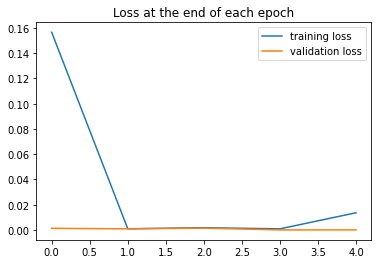

In [27]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

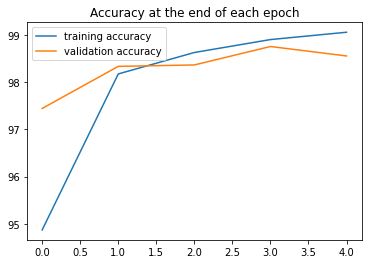

In [28]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [30]:
model.eval()
example = torch.rand(1,1,28,28).cuda()
traced_script_module = torch.jit.trace(model,example)

In [31]:
traced_script_module.save("ts_mnist.pt")

In [32]:
ts_model = torch.jit.load("ts_mnist.pt")

In [5]:
data_iter = iter(test_loader)
images,labels = data_iter.next()

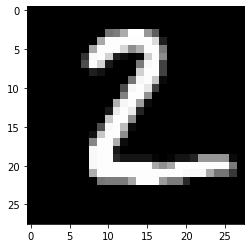

In [56]:
my_index = 1
plt.imshow(images[my_index].reshape(28,28),cmap='gray')

In [57]:
my_image = images[my_index]

In [58]:
my_image = torch.unsqueeze(my_image,0)

In [59]:
my_image.shape

torch.Size([1, 1, 28, 28])

In [60]:
result = ts_model(my_image.cuda())

In [61]:
prediction = result.argmax()
print('Choosen value:',prediction.item())

Choosen value: 2


In [62]:
result

tensor([[-2.1918e+01, -1.3275e+01, -1.9073e-06, -2.3876e+01, -2.1100e+01,
         -2.8660e+01, -2.7281e+01, -1.5506e+01, -2.3247e+01, -2.3988e+01]],
       device='cuda:0', grad_fn=<DifferentiableGraphBackward>)

In [31]:
import math

In [63]:
prob = math.exp(result[0][prediction.item()].item())

In [64]:
print(f'Predicted number: {prediction.item()}')
print(f'Confidence level: {round(100*prob,2)}%')

Predicted number: 2
Confidence level: 100.0%


In [4]:
# Loading in autoencoder model
aeModel = torch.jit.load('ts_autoencode.pt')
# Loading in mnist model
mnistModel = torch.jit.load('ts_mnist.pt')

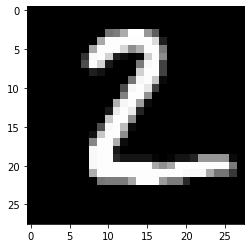

In [6]:
my_index = 1
plt.imshow(images[my_index].reshape(28,28),cmap='gray')

In [41]:
noisey = images[my_index] + torch.randn(images[0].size()) * 0.05 + 0.

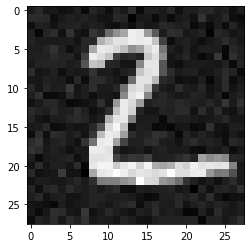

In [42]:
plt.imshow(noisey.reshape(28,28),cmap='gray')

In [43]:
# Running image through autoencoder
noisey = torch.unsqueeze(noisey,0)
print(noisey.shape)

torch.Size([1, 1, 28, 28])


In [44]:
ae_output = aeModel(noisey)

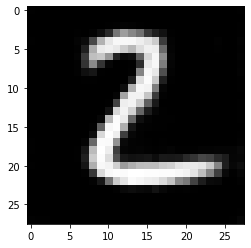

In [45]:
plt.imshow(ae_output.reshape(28,28).detach().numpy(),cmap='gray')

In [46]:
img_difference = abs(torch.subtract(noisey,ae_output))

In [47]:
print(img_difference.mean().item())
if img_difference.mean().item() > 0.1:
    print('Too much noise. Not running through MNIST classifier')
else:
    results = mnistModel(ae_output.cuda())

0.06572245806455612


In [48]:
results

tensor([[-1.9615e+01, -1.3033e+01, -2.9802e-06, -2.1487e+01, -1.9385e+01,
         -2.6454e+01, -2.5334e+01, -1.4062e+01, -2.1022e+01, -2.1715e+01]],
       device='cuda:0', grad_fn=<DifferentiableGraphBackward>)

In [49]:
prob = math.exp(results[0][results.argmax().item()].item())

print(f'Predicted number: {results.argmax().item()}')
print(f'Confidence level: {round(100*prob,2)}%')

Predicted number: 2
Confidence level: 100.0%
